In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
with open("../credenciales.json", 'r') as f:
    conn_data = json.load(f)

DB_CONN = f'mysql+mysqlconnector://{conn_data["username"]}:{conn_data["password"]}@{conn_data["host"]}/{conn_data["database"]}'

## Modelo con toda la base de datos

In [24]:
SQL = """ 
SELECT
    ad.Money,
    -- ad.Interior,
    -- ad.Dimension,
    LOWER(ad.Job) AS Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    -- DATEDIFF(CURDATE(), ad.LastOnline) AS DaysSinceLastOnline,
    ad.Kills,
    ad.Deaths,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account
"""

data = pd.read_sql(SQL, DB_CONN)

data["vip"] = data["vip"].map(lambda x: False if x in ["None", "false"] else True)

In [26]:
def Preprocess_input(data):
    # PREPROCESAMIENTOS
    data.drop_duplicates(inplace=True)

    # covertir a minusculas
    str_cols = data.select_dtypes(include="object").columns
    data[str_cols] = data[str_cols].apply(lambda x: x.str.lower())

    # filtrar y convertir variable Job a si tiene o no 
    data = data[~data["Job"].isin(["0", "banned"])]

    data["Job"] = data["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)

    return data

data = Preprocess_input(data)

/tmp/ipykernel_150638/134369737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Job"] = data["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)


In [27]:
X = data.drop(columns="vip")
y = data["vip"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [7, 9, 11, 13],
    # "min_samples_split": [3, 4, 5, 6, 7],
    # "min_samples_leaf": [3, 4, 5, 6, 7],
}

GVmodel1 = GridSearchCV(RandomForestClassifier(random_state=123), grid, cv=4, n_jobs=-1, verbose=3, scoring="recall")

GVmodel1.fit(X_train, y_train)

print(GVmodel1.best_params_)
print(GVmodel1.best_score_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[CV 1/4] END .......criterion=gini, max_depth=7;, score=0.022 total time=   2.3s
[CV 2/4] END .......criterion=gini, max_depth=7;, score=0.011 total time=   2.4s
[CV 3/4] END .......criterion=gini, max_depth=7;, score=0.011 total time=   2.3s
[CV 4/4] END .......criterion=gini, max_depth=7;, score=0.019 total time=   2.2s
[CV 1/4] END .......criterion=gini, max_depth=9;, score=0.025 total time=   3.0s
[CV 2/4] END .......criterion=gini, max_depth=9;, score=0.011 total time=   3.1s
[CV 3/4] END .......criterion=gini, max_depth=9;, score=0.011 total time=   2.7s
[CV 4/4] END .......criterion=gini, max_depth=9;, score=0.030 total time=   2.7s
[CV 1/4] END ......criterion=gini, max_depth=11;, score=0.033 total time=   3.2s
[CV 2/4] END ......criterion=gini, max_depth=11;, score=0.019 total time=   3.2s
[CV 3/4] END ......criterion=gini, max_depth=11;, score=0.011 total time=   3.3s
[CV 4/4] END ......criterion=gini, max_depth=11;, score=0.041 total time=   3.3s
[CV 1/4] END ......criterion

In [29]:
pd.Series(GVmodel1.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

Playtime_mins    0.239195
Bank_money       0.192599
Money            0.180616
Deaths           0.133627
Kills            0.126707
WL               0.086396
JailTime         0.021092
Job              0.019769
dtype: float64

In [30]:
print("PRUEBA")
print(classification_report(y_train, GVmodel1.predict(X_train)))

print("TEST")
print(classification_report(y_test, GVmodel1.predict(X_test)))

PRUEBA
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     38115
        True       1.00      0.16      0.27      1458

    accuracy                           0.97     39573
   macro avg       0.98      0.58      0.63     39573
weighted avg       0.97      0.97      0.96     39573

TEST
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      9553
        True       0.42      0.03      0.05       341

    accuracy                           0.97      9894
   macro avg       0.69      0.51      0.52      9894
weighted avg       0.95      0.97      0.95      9894



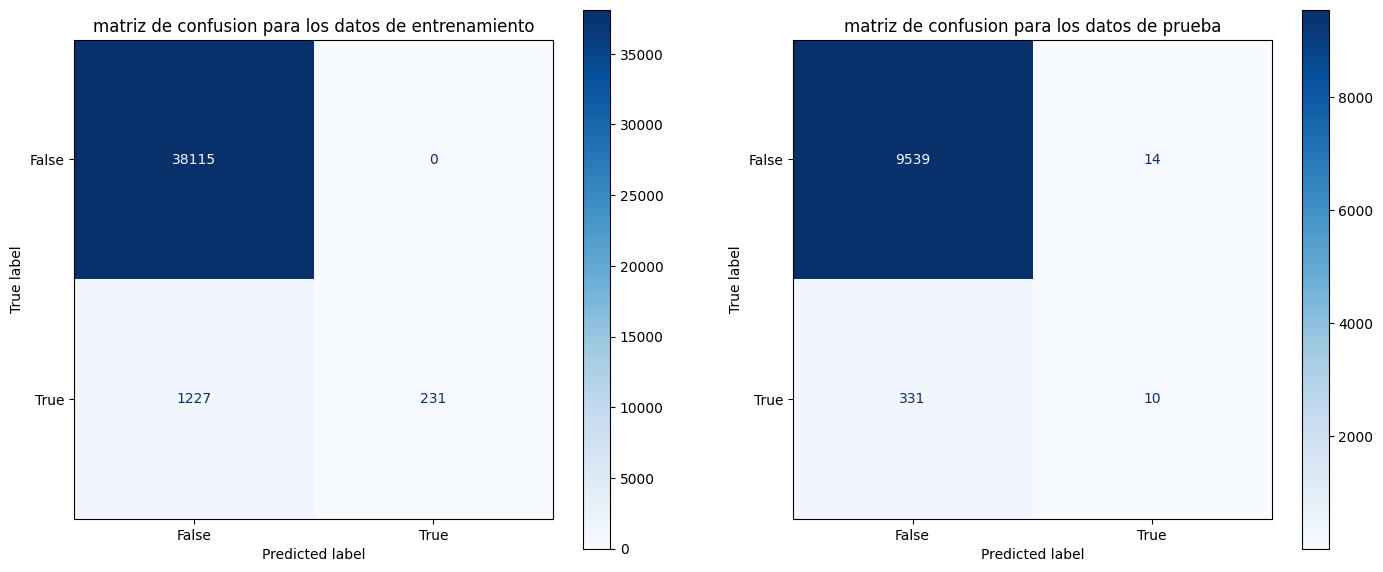

In [31]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel1.best_estimator_,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1,
    # normalize="true"
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel1.best_estimator_,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax2,
    # normalize="true"
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

como era de esperarse el modelo suele no fallar en la clasificacion de los verdaderos negativos, sin embargo si tiende a dar varios falsos negativos, osea que a veces clasifica a alguien que si compro el premium como si no lo hubiera comprado

## modelo con los usuarios que se han conectado en los ultimos 6 meses

In [17]:
SQL = """ 
SELECT
    ad.Money,
    ad.Interior,
    ad.Dimension,
    LOWER(ad.Job) AS Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    DATEDIFF(CURDATE(), ad.LastOnline) AS DaysSinceLastOnline,
    ad.Kills,
    ad.Deaths,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account
WHERE ad.LastOnline > '2023-05-01'
"""

data = pd.read_sql(SQL, DB_CONN)

data["vip"] = data["vip"].map(lambda x: False if x in ["None", "false"] else True)

In [20]:
data = Preprocess_input(data)

In [21]:
X = data.drop(columns="vip")
y = data["vip"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [22]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 9, 11],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
}

GVmodel2 = GridSearchCV(RandomForestClassifier(), grid, cv=4, n_jobs=-1, verbose=3)

GVmodel2.fit(X_train, y_train)

print(GVmodel2.best_params_)
print(GVmodel2.best_score_)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.982 total time=   0.4s
[CV 2/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.982 total time=   0.4s
[CV 3/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.983 total time=   0.4s
[CV 4/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.983 total time=   0.4s
[CV 1/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=3;, score=0.982 total time=   0.4s
[CV 2/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=3;, score=0.983 total time=   0.4s
[CV 3/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=3;, score=0.983 total time=   0.4s
[CV 4/4] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=3;, score=0.983 total time=   0.4s
[CV 1/4] END cri

In [26]:
print("PRUEBA")
print(classification_report(y_train, GVmodel2.predict(X_train)))

print("TEST")
print(classification_report(y_test, GVmodel2.predict(X_test)))

PRUEBA
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      6796
        True       1.00      0.26      0.42       122

    accuracy                           0.99      6918
   macro avg       0.99      0.63      0.70      6918
weighted avg       0.99      0.99      0.98      6918

TEST
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1702
        True       1.00      0.11      0.19        28

    accuracy                           0.99      1730
   macro avg       0.99      0.55      0.59      1730
weighted avg       0.99      0.99      0.98      1730



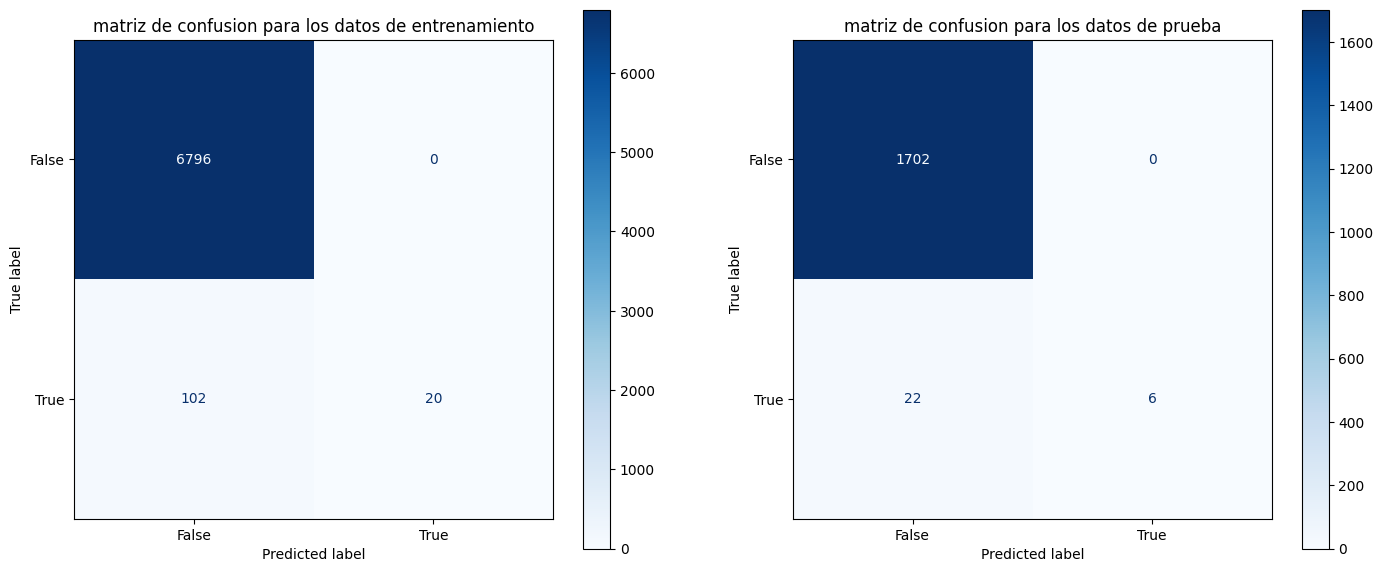

In [27]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel2.best_estimator_,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel2.best_estimator_,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax2
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

en este caso se ve un pesimo desempeño al predecir las personas que si compraron el premium, solo con estos datos el modelo tiende a dar muchos falsos negativos

## sadasd